In [1]:
import os
import tensorflow as tf

# Set CUDA device order and visible devices
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8,9"

# Set the device
device = '/cpu:0'
if tf.config.experimental.list_physical_devices('GPU'):
    try:
        # Restrict TensorFlow to only use the second GPU
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            tf.config.experimental.set_visible_devices(gpus[9], 'GPU')
            device = '/gpu:9'
    except RuntimeError as e:
        print(e)

print("device", device)

2024-07-25 20:38:49.346787: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-25 20:38:49.423554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 20:38:49.497508: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 20:38:49.532610: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 20:38:49.602165: I tensorflow/core/platform/cpu_feature_guar

device /gpu:9


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
# from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import h5py

In [4]:
    
import h5py
import numpy as np

def load_data(file_path, num_images):
    images = []
    # bounding_boxes = []
    centers = []

    with h5py.File(file_path, 'r') as h5file:
        for i in range(num_images):
            # Load image data
            image_dataset = f'image_{i}_image'
            image_data = np.array(h5file[image_dataset])
            images.append(image_data)

            # # Load bounding boxes
            # bbox_dataset = f'image_{i}_bounding_boxes_training'
            # bbox_data = np.array(h5file[bbox_dataset])
            # bounding_boxes.append(bbox_data)

            # Load center positions
            center_dataset = f'image_{i}_center_positions_training'
            center_data = np.array(h5file[center_dataset])
            centers.append(center_data)

    # Convert lists to NumPy arrays for easier handling in deep learning pipelines
    images = np.array(images)
    # bounding_boxes = np.array(bounding_boxes)
    centers = np.array(centers)

    return images, centers

# # Example usage
file_path = '/home/da886/ElectronCountingProject/60KImages_64x64Training10electronhits.h5'  ####for training
num_images = 60000

# file_path = '/home/da886/ElectronCountingProject/500Images_64x64Testing10electronhits.h5'  ####for testing
# num_images = 500

images, centers = load_data(file_path, num_images)

# Verify shapes
print(f'Images shape: {images.shape}')
# print(f'Bounding boxes shape: {bounding_boxes.shape}')
print(f'Centers shape: {centers.shape}')


Images shape: (60000, 64, 64)
Centers shape: (60000, 12, 3)


In [5]:
# # Assuming images and centers are already defined
# image_normalized = (images + 1e-9) / 9.26
# center_coordinates = centers / [1, 64, 64]  # Normalizing the center coordinates
# images_np = image_normalized

# probabilities = np.array(center_coordinates[:, :, :-2])
# probabilities =  tf.expand_dims(probabilities, axis=1)
# center_coordinates_np = np.array(center_coordinates[:, :, 1:])
# center_coordinates_np = tf.expand_dims(center_coordinates_np, axis=1)
# batch_size = 256
# dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_midpoints_reshape': center_coordinates_np}))
# dataset = dataset.shuffle(buffer_size=512,reshuffle_each_iteration= True).batch(batch_size)


# Assuming images and centers are already defined
image_normalized = (images + 1e-9) / 9.26
center_coordinates = centers / [1, 64, 64]  # Normalizing the center coordinates
images_np = image_normalized
probabilities = np.array(center_coordinates[:, :, :-2])
probabilities =  tf.expand_dims(probabilities, axis=1)
center_coordinates_np = np.array(center_coordinates[:, :, 1:])
center_coordinates_np = tf.expand_dims(center_coordinates_np, axis=1)
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_midpoints_reshape': center_coordinates_np}))
# dataset = dataset.shuffle(buffer_size=10000,reshuffle_each_iteration= True).batch(batch_size)
# # Determine the size of the dataset
dataset_size = len(images_np)

# Calculate the number of samples for training (e.g., 80% for training, 20% for validation)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Shuffle each dataset separately
train_dataset = train_dataset.shuffle(buffer_size=512,reshuffle_each_iteration= True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=512,reshuffle_each_iteration= True).batch(batch_size)

# Prefetch to improve performance
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)


2024-07-25 20:41:14.168111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 9, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:cf:00.0, compute capability: 8.0


In [5]:
center_coordinates_np[9]

<tf.Tensor: shape=(1, 12, 2), dtype=float64, numpy=
array([[[0.4609375, 0.6953125],
        [0.1796875, 0.6640625],
        [0.3828125, 0.4765625],
        [0.9765625, 0.4453125],
        [0.0234375, 0.6640625],
        [0.9609375, 0.6171875],
        [0.7265625, 0.1015625],
        [0.3046875, 0.6015625],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ]]])>

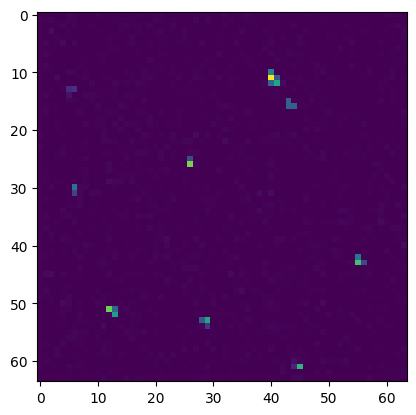

In [6]:
plt.imshow(images_np[1])

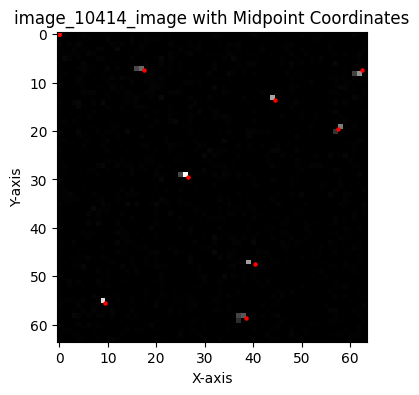

In [10]:
# # File path to the HDF5 file
# file_path = '/home/da886/ElectronCountingProject/60KImages_64x64Training10electronhits.h5'

# # Function to visualize the first image with midpoint coordinates
# def visualize_first_image_with_midpoints(file_path):
#     # Open the HDF5 file
#     h5_file = h5py.File(file_path, 'r')

#     # Get the list of image keys and midpoint keys
#     image_keys = [key for key in h5_file.keys() if 'image' in key and '_image' in key]
#     midpoint_keys = [key for key in h5_file.keys() if 'center_positions' in key and '_center_positions' in key]

#     d = np.random.randint(0, 10000)
#     # Select the first key for visualization
#     selected_image_key = image_keys[d]
#     selected_midpoint_key = selected_image_key.replace('_image', '_center_positions')

#     # Extract the image and midpoint coordinates
#     image_data = h5_file[selected_image_key][:]
#     midpoints = h5_file[selected_midpoint_key][:]
    
#     # Close the file
#     h5_file.close()

#     # Plot the first image with midpoint coordinates
#     plt.figure(figsize=(4, 5))
#     plt.imshow(image_data, cmap='gray')
#     plt.scatter(midpoints[:, 0], midpoints[:, 1], c='red', s=5)
#     plt.title(f'{selected_image_key} with Midpoint Coordinates')
#     plt.xlabel('X-axis')
#     plt.ylabel('Y-axis')
#     plt.show()

# # Call the function with the file path
# visualize_first_image_with_midpoints(file_path)

(array([[3., 1., 1., 0., 0., 0., 1., 3., 0., 3.],
        [3., 2., 0., 0., 1., 1., 2., 1., 2., 0.]]),
 array([0.        , 0.09921875, 0.1984375 , 0.29765625, 0.396875  ,
        0.49609375, 0.5953125 , 0.69453125, 0.79375   , 0.89296875,
        0.9921875 ]),
 <a list of 2 BarContainer objects>)

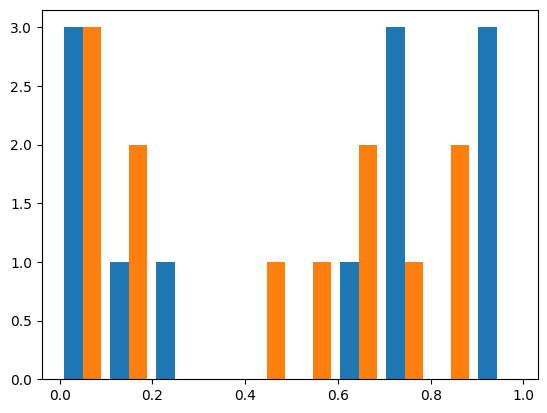

In [7]:
# p = np.random.randint(0,len(center_coordinates_np))
# center_coordinates_np[p]
plt.hist(center_coordinates_np[9].numpy().squeeze())

Josh's suggestion

In [5]:
# input_shape = (64, 64, 1)
# num_classes = 12
# num_coordinates = 2


# x_input = layers.Input(shape=input_shape)
# #Layer 1
# x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x_input)
# x = layers.MaxPool2D()(x)
# x = layers.BatchNormalization()(x) 
# x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)

# # #Layer 2
# # x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
# # x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)

# # #Layer 3
# # x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
# # x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)

# # #Layer 4
# # x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
# # x = layers.MaxPool2D()(x)
# # x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
# # x = layers.MaxPool2D()(x)
# # x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
# # x = layers.MaxPool2D()(x)

# #Layer 5
# x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
# x = layers.MaxPool2D()(x)
# x = layers.BatchNormalization()(x) 


# x = layers.Flatten()(x)
# # Probability output
# x_prob = layers.Dense(num_classes, activation='sigmoid', name='x_prob')(x)
# x_prob_reshape = layers.Reshape((-1,num_classes,1), name='x_prob_reshape')(x_prob)

# # Bounding box output
# x_midpoints = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_midpoints')(x)
# x_midpoints_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_midpoints_reshape')(x_midpoints)




# model = tf.keras.models.Model(x_input, [x_prob_reshape,x_midpoints_reshape])
# optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) 


In [5]:
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

input_shape = (64, 64, 1)
num_classes = 12
num_coordinates = 2


x_input = layers.Input(shape=input_shape)
#Layer 1
x = layers.Conv2D(1025, kernel_size=3, padding='same', activation='relu')(x_input)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 
# x = layers.Dropout(0.3)(x) 


x = layers.Flatten()(x)
# Probability output
x_prob = layers.Dense(num_classes, activation='sigmoid', name='x_prob')(x)
x_prob_reshape = layers.Reshape((-1,num_classes,1), name='x_prob_reshape')(x_prob)

# Bounding box output
x_midpoints = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_midpoints')(x)
x_midpoints_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_midpoints_reshape')(x_midpoints)




model = tf.keras.models.Model(x_input, [x_prob_reshape,x_midpoints_reshape])
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) 



In [6]:
@tf.keras.utils.register_keras_serializable()
class MaskedMeanSquaredError(tf.keras.losses.Loss):
    def __init__(self, name="masked_mse_loss", **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, y_true, y_pred):
        # Create mask
        mask = tf.reduce_sum(y_true, axis=-1) > 0
        mask = tf.cast(mask, tf.float32)
        mask = tf.expand_dims(mask, axis=-1)

        # Apply mask to the true and predicted values
        y_true_masked = y_true * mask
        y_pred_masked = y_pred * mask

        # Calculate mean squared error
        mse = tf.reduce_mean(tf.square(y_true_masked - y_pred_masked), axis=-1)
        # mse = tf.keras.losses.MeanSquaredError(y_true_masked,y_pred_masked)
        # Normalize the loss by the number of non-zero elements in the mask
        mask_sum = tf.reduce_sum(mask)
        masked_loss = tf.reduce_sum(mse) / mask_sum
        return masked_loss


@tf.keras.utils.register_keras_serializable()
class MaskedBinaryCrossentropy(tf.keras.losses.Loss):
    def __init__(self, name="masked_binary_crossentropy", **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, y_true, y_pred):
        # Create mask
        mask = tf.reduce_sum(y_true, axis=-1) > 0
        mask = tf.cast(mask, tf.float32)
        mask = tf.expand_dims(mask, axis=-1)

        # Apply mask to the true and predicted values
        y_true_masked = y_true * mask
        y_pred_masked = y_pred * mask

        # Calculate binary cross-entropy
        bce = tf.keras.losses.binary_crossentropy(y_true_masked, y_pred_masked)

        # Normalize the loss by the number of non-zero elements in the mask
        mask_sum = tf.reduce_sum(mask)
        masked_loss = tf.reduce_sum(bce) / mask_sum
        return masked_loss


In [7]:

model.compile(optimizer= optimizer, loss= {'x_prob_reshape': MaskedBinaryCrossentropy(), 'x_midpoints_reshape':MaskedMeanSquaredError()})   


In [10]:
# model = tf.keras.models.load_model("/home/da886/ElectronCountingProject/Weights from my data/weights for Josh's relu/10000images.keras") ####the weights are for 60000images. it was a typo

In [9]:
from tensorflow.keras import layers, callbacks
# Custom callback to save the model every 10 epochs
class CustomModelCheckpoint(callbacks.Callback):
    def __init__(self, save_freq, save_path):
        super(CustomModelCheckpoint, self).__init__()
        self.save_freq = save_freq
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(self.save_path.format(epoch=epoch + 1))
            print(f"Model saved at epoch {epoch + 1}")

save_freq = 20  # Save every 10 epochs
save_path = "/home/da886/ElectronCountingProject/Weights from my data/weights for Josh's relu/myversionnew_epoch_{epoch:02d}.h5"
checkpoint_callback = CustomModelCheckpoint(save_freq=save_freq, save_path=save_path)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=8, min_lr=3e-5, verbose=1)

In [10]:
model.fit(train_dataset,epochs=700,validation_data=val_dataset,callbacks =[checkpoint_callback])

Epoch 1/700


I0000 00:00:1721842273.164868 1145526 service.cc:146] XLA service 0x7fb8280047a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721842273.165188 1145526 service.cc:154]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-07-24 17:31:13.210435: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-24 17:31:13.576527: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-07-24 17:31:24.997954: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[128,1025,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,512,32,32]{3,2,1,0}, f32[512,1025,5,5]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_

  1/375 ━━━━━━━━━━━━━━━━━━━━ 5:21:48 52s/step - loss: 1.0075

I0000 00:00:1721842319.487169 1145526 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 114s 167ms/step - loss: 0.1697 - val_loss: 0.1107
Epoch 2/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 149ms/step - loss: 0.0898 - val_loss: 0.0901
Epoch 3/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - loss: 0.0845 - val_loss: 0.0893
Epoch 4/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 147ms/step - loss: 0.0801 - val_loss: 0.0887
Epoch 5/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 154ms/step - loss: 0.0766 - val_loss: 0.0885
Epoch 6/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 79s 146ms/step - loss: 0.0735 - val_loss: 0.0886
Epoch 7/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 151ms/step - loss: 0.0707 - val_loss: 0.0886
Epoch 8/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step - loss: 0.0680 - val_loss: 0.0900
Epoch 9/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 152ms/step - loss: 0.0652 - val_loss: 0.0908
Epoch 10/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step - loss: 0.0627 - val_loss: 0.0923
Epoch 11/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step - loss: 0.0604 - val_loss: 0.0936
Epoch 12/700
375/37

Model saved at epoch 20
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 148ms/step - loss: 0.0417 - val_loss: 0.1077
Epoch 21/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0401 - val_loss: 0.1095
Epoch 22/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - loss: 0.0386 - val_loss: 0.1115
Epoch 23/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 152ms/step - loss: 0.0371 - val_loss: 0.1137
Epoch 24/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 154ms/step - loss: 0.0356 - val_loss: 0.1145
Epoch 25/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 153ms/step - loss: 0.0343 - val_loss: 0.1157
Epoch 26/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 149ms/step - loss: 0.0329 - val_loss: 0.1172
Epoch 27/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step - loss: 0.0316 - val_loss: 0.1190
Epoch 28/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 80s 145ms/step - loss: 0.0304 - val_loss: 0.1204
Epoch 29/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0293 - val_loss: 0.1223
Epoch 30/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - loss: 0.0283 - val_l

Model saved at epoch 40
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 147ms/step - loss: 0.0198 - val_loss: 0.1318
Epoch 41/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 152ms/step - loss: 0.0192 - val_loss: 0.1329
Epoch 42/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step - loss: 0.0186 - val_loss: 0.1333
Epoch 43/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 80s 147ms/step - loss: 0.0181 - val_loss: 0.1340
Epoch 44/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 153ms/step - loss: 0.0175 - val_loss: 0.1348
Epoch 45/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 148ms/step - loss: 0.0170 - val_loss: 0.1355
Epoch 46/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 152ms/step - loss: 0.0166 - val_loss: 0.1358
Epoch 47/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 150ms/step - loss: 0.0161 - val_loss: 0.1364
Epoch 48/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - loss: 0.0156 - val_loss: 0.1372
Epoch 49/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0153 - val_loss: 0.1383
Epoch 50/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step - loss: 0.0149 - val_l

Model saved at epoch 60
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 153ms/step - loss: 0.0117 - val_loss: 0.1444
Epoch 61/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 149ms/step - loss: 0.0115 - val_loss: 0.1444
Epoch 62/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 154ms/step - loss: 0.0112 - val_loss: 0.1447
Epoch 63/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 153ms/step - loss: 0.0110 - val_loss: 0.1454
Epoch 64/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - loss: 0.0108 - val_loss: 0.1453
Epoch 65/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 148ms/step - loss: 0.0106 - val_loss: 0.1455
Epoch 66/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0104 - val_loss: 0.1458
Epoch 67/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 152ms/step - loss: 0.0102 - val_loss: 0.1455
Epoch 68/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step - loss: 0.0100 - val_loss: 0.1461
Epoch 69/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step - loss: 0.0098 - val_loss: 0.1460
Epoch 70/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 153ms/step - loss: 0.0096 - val_l

Model saved at epoch 80
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 153ms/step - loss: 0.0080 - val_loss: 0.1457
Epoch 81/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 156ms/step - loss: 0.0079 - val_loss: 0.1461
Epoch 82/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 153ms/step - loss: 0.0077 - val_loss: 0.1459
Epoch 83/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 150ms/step - loss: 0.0076 - val_loss: 0.1460
Epoch 84/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - loss: 0.0075 - val_loss: 0.1454
Epoch 85/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - loss: 0.0074 - val_loss: 0.1455
Epoch 86/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0072 - val_loss: 0.1452
Epoch 87/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - loss: 0.0072 - val_loss: 0.1455
Epoch 88/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 80s 145ms/step - loss: 0.0070 - val_loss: 0.1449
Epoch 89/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 147ms/step - loss: 0.0069 - val_loss: 0.1453
Epoch 90/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 153ms/step - loss: 0.0068 - val_l

Model saved at epoch 100
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0059 - val_loss: 0.1435
Epoch 101/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0058 - val_loss: 0.1437
Epoch 102/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 152ms/step - loss: 0.0057 - val_loss: 0.1438
Epoch 103/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 152ms/step - loss: 0.0056 - val_loss: 0.1434
Epoch 104/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 145ms/step - loss: 0.0056 - val_loss: 0.1434
Epoch 105/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 154ms/step - loss: 0.0055 - val_loss: 0.1432
Epoch 106/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 79s 146ms/step - loss: 0.0054 - val_loss: 0.1434
Epoch 107/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - loss: 0.0053 - val_loss: 0.1431
Epoch 108/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - loss: 0.0052 - val_loss: 0.1427
Epoch 109/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0052 - val_loss: 0.1429
Epoch 110/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step - loss: 0.0

Model saved at epoch 120
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 147ms/step - loss: 0.0045 - val_loss: 0.1407
Epoch 121/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 145ms/step - loss: 0.0045 - val_loss: 0.1414
Epoch 122/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step - loss: 0.0044 - val_loss: 0.1414
Epoch 123/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 153ms/step - loss: 0.0043 - val_loss: 0.1410
Epoch 124/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 78s 143ms/step - loss: 0.0043 - val_loss: 0.1404
Epoch 125/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - loss: 0.0042 - val_loss: 0.1401
Epoch 126/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 83s 147ms/step - loss: 0.0042 - val_loss: 0.1406
Epoch 127/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 145ms/step - loss: 0.0041 - val_loss: 0.1401
Epoch 128/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - loss: 0.0040 - val_loss: 0.1403
Epoch 129/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 144ms/step - loss: 0.0040 - val_loss: 0.1403
Epoch 130/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step - loss: 0.0

Model saved at epoch 140
375/375 ━━━━━━━━━━━━━━━━━━━━ 60s 159ms/step - loss: 0.0035 - val_loss: 0.1391
Epoch 141/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 158ms/step - loss: 0.0035 - val_loss: 0.1388
Epoch 142/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 157ms/step - loss: 0.0035 - val_loss: 0.1391
Epoch 143/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 61s 161ms/step - loss: 0.0034 - val_loss: 0.1381
Epoch 144/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 61s 163ms/step - loss: 0.0034 - val_loss: 0.1383
Epoch 145/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 158ms/step - loss: 0.0033 - val_loss: 0.1381
Epoch 146/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 155ms/step - loss: 0.0033 - val_loss: 0.1373
Epoch 147/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 155ms/step - loss: 0.0033 - val_loss: 0.1379
Epoch 148/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 155ms/step - loss: 0.0033 - val_loss: 0.1375
Epoch 149/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 78s 144ms/step - loss: 0.0032 - val_loss: 0.1376
Epoch 150/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 144ms/step - loss: 0.0

Model saved at epoch 160
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step - loss: 0.0029 - val_loss: 0.1362
Epoch 161/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 83s 155ms/step - loss: 0.0029 - val_loss: 0.1357
Epoch 162/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - loss: 0.0028 - val_loss: 0.1362
Epoch 163/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step - loss: 0.0028 - val_loss: 0.1359
Epoch 164/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 144ms/step - loss: 0.0028 - val_loss: 0.1357
Epoch 165/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - loss: 0.0028 - val_loss: 0.1355
Epoch 166/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0028 - val_loss: 0.1359
Epoch 167/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - loss: 0.0027 - val_loss: 0.1356
Epoch 168/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - loss: 0.0027 - val_loss: 0.1353
Epoch 169/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - loss: 0.0027 - val_loss: 0.1355
Epoch 170/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - loss: 0.0

Model saved at epoch 180
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - loss: 0.0024 - val_loss: 0.1346
Epoch 181/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - loss: 0.0024 - val_loss: 0.1341
Epoch 182/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 152ms/step - loss: 0.0024 - val_loss: 0.1345
Epoch 183/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 83s 155ms/step - loss: 0.0024 - val_loss: 0.1343
Epoch 184/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 149ms/step - loss: 0.0024 - val_loss: 0.1338
Epoch 185/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 156ms/step - loss: 0.0024 - val_loss: 0.1343
Epoch 186/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 156ms/step - loss: 0.0024 - val_loss: 0.1338
Epoch 187/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 157ms/step - loss: 0.0023 - val_loss: 0.1339
Epoch 188/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0023 - val_loss: 0.1338
Epoch 189/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 158ms/step - loss: 0.0023 - val_loss: 0.1337
Epoch 190/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 61s 163ms/step - loss: 0.0

Model saved at epoch 200
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 153ms/step - loss: 0.0021 - val_loss: 0.1327
Epoch 201/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 154ms/step - loss: 0.0021 - val_loss: 0.1327
Epoch 202/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - loss: 0.0021 - val_loss: 0.1324
Epoch 203/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - loss: 0.0021 - val_loss: 0.1323
Epoch 204/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 145ms/step - loss: 0.0021 - val_loss: 0.1325
Epoch 205/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - loss: 0.0021 - val_loss: 0.1325
Epoch 206/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - loss: 0.0021 - val_loss: 0.1322
Epoch 207/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 152ms/step - loss: 0.0020 - val_loss: 0.1325
Epoch 208/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 147ms/step - loss: 0.0020 - val_loss: 0.1322
Epoch 209/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 145ms/step - loss: 0.0020 - val_loss: 0.1321
Epoch 210/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 154ms/step - loss: 0.0

Model saved at epoch 220
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0018 - val_loss: 0.1315
Epoch 221/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - loss: 0.0019 - val_loss: 0.1316
Epoch 222/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0019 - val_loss: 0.1313
Epoch 223/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 151ms/step - loss: 0.0018 - val_loss: 0.1314
Epoch 224/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 148ms/step - loss: 0.0018 - val_loss: 0.1309
Epoch 225/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - loss: 0.0018 - val_loss: 0.1311
Epoch 226/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 152ms/step - loss: 0.0018 - val_loss: 0.1310
Epoch 227/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 152ms/step - loss: 0.0018 - val_loss: 0.1310
Epoch 228/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 79s 145ms/step - loss: 0.0018 - val_loss: 0.1311
Epoch 229/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - loss: 0.0018 - val_loss: 0.1310
Epoch 230/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - loss: 0.0

Model saved at epoch 240
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 147ms/step - loss: 0.0016 - val_loss: 0.1303
Epoch 241/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 145ms/step - loss: 0.0017 - val_loss: 0.1305
Epoch 242/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 144ms/step - loss: 0.0016 - val_loss: 0.1306
Epoch 243/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 84s 149ms/step - loss: 0.0016 - val_loss: 0.1308
Epoch 244/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 79s 143ms/step - loss: 0.0016 - val_loss: 0.1307
Epoch 245/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 143ms/step - loss: 0.0016 - val_loss: 0.1304
Epoch 246/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 144ms/step - loss: 0.0016 - val_loss: 0.1302
Epoch 247/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - loss: 0.0016 - val_loss: 0.1299
Epoch 248/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 147ms/step - loss: 0.0016 - val_loss: 0.1306
Epoch 249/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 147ms/step - loss: 0.0016 - val_loss: 0.1302
Epoch 250/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - loss: 0.0

Model saved at epoch 260
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 156ms/step - loss: 0.0015 - val_loss: 0.1297
Epoch 261/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 154ms/step - loss: 0.0015 - val_loss: 0.1296
Epoch 262/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 149ms/step - loss: 0.0015 - val_loss: 0.1292
Epoch 263/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - loss: 0.0015 - val_loss: 0.1296
Epoch 264/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0015 - val_loss: 0.1293
Epoch 265/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step - loss: 0.0015 - val_loss: 0.1293
Epoch 266/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - loss: 0.0015 - val_loss: 0.1295
Epoch 267/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 147ms/step - loss: 0.0014 - val_loss: 0.1296
Epoch 268/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 147ms/step - loss: 0.0014 - val_loss: 0.1293
Epoch 269/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step - loss: 0.0014 - val_loss: 0.1294
Epoch 270/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 153ms/step - loss: 0.0

Model saved at epoch 280
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 144ms/step - loss: 0.0014 - val_loss: 0.1290
Epoch 281/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 83s 148ms/step - loss: 0.0013 - val_loss: 0.1290
Epoch 282/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 147ms/step - loss: 0.0013 - val_loss: 0.1288
Epoch 283/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 144ms/step - loss: 0.0013 - val_loss: 0.1289
Epoch 284/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 144ms/step - loss: 0.0013 - val_loss: 0.1288
Epoch 285/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - loss: 0.0013 - val_loss: 0.1290
Epoch 286/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 152ms/step - loss: 0.0013 - val_loss: 0.1288
Epoch 287/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 153ms/step - loss: 0.0013 - val_loss: 0.1285
Epoch 288/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 147ms/step - loss: 0.0013 - val_loss: 0.1286
Epoch 289/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 148ms/step - loss: 0.0013 - val_loss: 0.1284
Epoch 290/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 145ms/step - loss: 0.0

Model saved at epoch 300
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 153ms/step - loss: 0.0012 - val_loss: 0.1286
Epoch 301/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - loss: 0.0012 - val_loss: 0.1281
Epoch 302/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0012 - val_loss: 0.1283
Epoch 303/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - loss: 0.0012 - val_loss: 0.1283
Epoch 304/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 155ms/step - loss: 0.0012 - val_loss: 0.1278
Epoch 305/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 147ms/step - loss: 0.0012 - val_loss: 0.1282
Epoch 306/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 147ms/step - loss: 0.0012 - val_loss: 0.1283
Epoch 307/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 148ms/step - loss: 0.0012 - val_loss: 0.1282
Epoch 308/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0012 - val_loss: 0.1278
Epoch 309/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0012 - val_loss: 0.1283
Epoch 310/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step - loss: 0.0

Model saved at epoch 320
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 147ms/step - loss: 0.0011 - val_loss: 0.1274
Epoch 321/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 149ms/step - loss: 0.0011 - val_loss: 0.1276
Epoch 322/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 148ms/step - loss: 0.0011 - val_loss: 0.1272
Epoch 323/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step - loss: 0.0011 - val_loss: 0.1273
Epoch 324/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 158ms/step - loss: 0.0011 - val_loss: 0.1274
Epoch 325/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 77s 144ms/step - loss: 0.0011 - val_loss: 0.1276
Epoch 326/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 149ms/step - loss: 0.0011 - val_loss: 0.1279
Epoch 327/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 144ms/step - loss: 0.0011 - val_loss: 0.1276
Epoch 328/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - loss: 0.0011 - val_loss: 0.1277
Epoch 329/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0011 - val_loss: 0.1273
Epoch 330/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - loss: 0.0

Model saved at epoch 340
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 157ms/step - loss: 0.0011 - val_loss: 0.1271
Epoch 341/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 158ms/step - loss: 0.0011 - val_loss: 0.1270
Epoch 342/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 80s 153ms/step - loss: 0.0011 - val_loss: 0.1272
Epoch 343/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0011 - val_loss: 0.1269
Epoch 344/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - loss: 0.0011 - val_loss: 0.1269
Epoch 345/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 151ms/step - loss: 0.0010 - val_loss: 0.1271
Epoch 346/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 64s 170ms/step - loss: 0.0010 - val_loss: 0.1271
Epoch 347/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 188ms/step - loss: 0.0010 - val_loss: 0.1271
Epoch 348/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 84s 195ms/step - loss: 0.0011 - val_loss: 0.1272
Epoch 349/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - loss: 0.0010 - val_loss: 0.1271
Epoch 350/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 185ms/step - loss: 0.0

Model saved at epoch 360
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 201ms/step - loss: 0.0010 - val_loss: 0.1263
Epoch 361/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 183ms/step - loss: 0.0010 - val_loss: 0.1264
Epoch 362/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 184ms/step - loss: 9.9378e-04 - val_loss: 0.1265
Epoch 363/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 183ms/step - loss: 9.8437e-04 - val_loss: 0.1267
Epoch 364/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 183ms/step - loss: 9.7854e-04 - val_loss: 0.1264
Epoch 365/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 184ms/step - loss: 9.7715e-04 - val_loss: 0.1263
Epoch 366/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 73s 193ms/step - loss: 9.8192e-04 - val_loss: 0.1267
Epoch 367/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 74s 195ms/step - loss: 9.8135e-04 - val_loss: 0.1267
Epoch 368/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 77s 181ms/step - loss: 9.7100e-04 - val_loss: 0.1267
Epoch 369/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 184ms/step - loss: 9.6430e-04 - val_loss: 0.1264
Epoch 370/700
375/375 ━━━━━━━━━━━━━━━

Model saved at epoch 380
375/375 ━━━━━━━━━━━━━━━━━━━━ 77s 203ms/step - loss: 9.4475e-04 - val_loss: 0.1261
Epoch 381/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 77s 191ms/step - loss: 9.1170e-04 - val_loss: 0.1261
Epoch 382/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 186ms/step - loss: 9.1337e-04 - val_loss: 0.1261
Epoch 383/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 186ms/step - loss: 9.1025e-04 - val_loss: 0.1260
Epoch 384/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 185ms/step - loss: 9.2643e-04 - val_loss: 0.1260
Epoch 385/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 183ms/step - loss: 9.4691e-04 - val_loss: 0.1260
Epoch 386/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 187ms/step - loss: 9.2353e-04 - val_loss: 0.1259
Epoch 387/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 184ms/step - loss: 9.0544e-04 - val_loss: 0.1263
Epoch 388/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 186ms/step - loss: 8.9411e-04 - val_loss: 0.1262
Epoch 389/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 187ms/step - loss: 9.0166e-04 - val_loss: 0.1260
Epoch 390/700
375/375 ━━━━━━━

Model saved at epoch 400
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 201ms/step - loss: 8.8774e-04 - val_loss: 0.1259
Epoch 401/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 184ms/step - loss: 8.8234e-04 - val_loss: 0.1259
Epoch 402/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 74s 195ms/step - loss: 8.7731e-04 - val_loss: 0.1259
Epoch 403/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 184ms/step - loss: 8.6738e-04 - val_loss: 0.1257
Epoch 404/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 185ms/step - loss: 8.7288e-04 - val_loss: 0.1260
Epoch 405/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 185ms/step - loss: 8.7480e-04 - val_loss: 0.1258
Epoch 406/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 186ms/step - loss: 8.6124e-04 - val_loss: 0.1258
Epoch 407/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 183ms/step - loss: 8.6121e-04 - val_loss: 0.1257
Epoch 408/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 183ms/step - loss: 8.5361e-04 - val_loss: 0.1258
Epoch 409/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 183ms/step - loss: 8.5109e-04 - val_loss: 0.1255
Epoch 410/700
375/375 ━━━━━━━

Model saved at epoch 420
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 200ms/step - loss: 8.1825e-04 - val_loss: 0.1254
Epoch 421/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 184ms/step - loss: 8.2568e-04 - val_loss: 0.1253
Epoch 422/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 182ms/step - loss: 8.3006e-04 - val_loss: 0.1253
Epoch 423/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 185ms/step - loss: 8.2578e-04 - val_loss: 0.1250
Epoch 424/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 184ms/step - loss: 8.1296e-04 - val_loss: 0.1254
Epoch 425/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 182ms/step - loss: 8.1245e-04 - val_loss: 0.1253
Epoch 426/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 182ms/step - loss: 8.1593e-04 - val_loss: 0.1253
Epoch 427/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 183ms/step - loss: 8.1410e-04 - val_loss: 0.1253
Epoch 428/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 183ms/step - loss: 8.0584e-04 - val_loss: 0.1254
Epoch 429/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 185ms/step - loss: 7.9924e-04 - val_loss: 0.1255
Epoch 430/700
375/375 ━━━━━━━

Model saved at epoch 440
375/375 ━━━━━━━━━━━━━━━━━━━━ 79s 210ms/step - loss: 7.8223e-04 - val_loss: 0.1251
Epoch 441/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 186ms/step - loss: 7.8242e-04 - val_loss: 0.1251
Epoch 442/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 75s 199ms/step - loss: 7.8281e-04 - val_loss: 0.1250
Epoch 443/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 201ms/step - loss: 7.8059e-04 - val_loss: 0.1248
Epoch 444/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 188ms/step - loss: 7.6331e-04 - val_loss: 0.1248
Epoch 445/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 74s 196ms/step - loss: 7.5606e-04 - val_loss: 0.1248
Epoch 446/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 78s 186ms/step - loss: 7.5342e-04 - val_loss: 0.1246
Epoch 447/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 180ms/step - loss: 7.6100e-04 - val_loss: 0.1248
Epoch 448/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 183ms/step - loss: 7.6710e-04 - val_loss: 0.1246
Epoch 449/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 178ms/step - loss: 7.8015e-04 - val_loss: 0.1247
Epoch 450/700
375/375 ━━━━━━━

Model saved at epoch 460
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 200ms/step - loss: 7.3780e-04 - val_loss: 0.1246
Epoch 461/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 184ms/step - loss: 7.5106e-04 - val_loss: 0.1248
Epoch 462/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 182ms/step - loss: 7.4911e-04 - val_loss: 0.1247
Epoch 463/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 180ms/step - loss: 7.3959e-04 - val_loss: 0.1246
Epoch 464/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 183ms/step - loss: 7.3270e-04 - val_loss: 0.1247
Epoch 465/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 182ms/step - loss: 7.2879e-04 - val_loss: 0.1247
Epoch 466/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 180ms/step - loss: 7.2049e-04 - val_loss: 0.1248
Epoch 467/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 177ms/step - loss: 7.2283e-04 - val_loss: 0.1248
Epoch 468/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 177ms/step - loss: 7.3088e-04 - val_loss: 0.1244
Epoch 469/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 178ms/step - loss: 7.3586e-04 - val_loss: 0.1247
Epoch 470/700
375/375 ━━━━━━━

Model saved at epoch 480
375/375 ━━━━━━━━━━━━━━━━━━━━ 73s 193ms/step - loss: 7.1576e-04 - val_loss: 0.1245
Epoch 481/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 178ms/step - loss: 7.2015e-04 - val_loss: 0.1244
Epoch 482/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 176ms/step - loss: 7.0611e-04 - val_loss: 0.1242
Epoch 483/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 179ms/step - loss: 6.9503e-04 - val_loss: 0.1246
Epoch 484/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 177ms/step - loss: 6.9351e-04 - val_loss: 0.1241
Epoch 485/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 177ms/step - loss: 6.9975e-04 - val_loss: 0.1243
Epoch 486/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 178ms/step - loss: 7.0905e-04 - val_loss: 0.1244
Epoch 487/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 176ms/step - loss: 7.0295e-04 - val_loss: 0.1244
Epoch 488/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 177ms/step - loss: 6.9253e-04 - val_loss: 0.1242
Epoch 489/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 178ms/step - loss: 6.8536e-04 - val_loss: 0.1246
Epoch 490/700
375/375 ━━━━━━━

Model saved at epoch 500
375/375 ━━━━━━━━━━━━━━━━━━━━ 72s 190ms/step - loss: 6.7910e-04 - val_loss: 0.1244
Epoch 501/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 6.7925e-04 - val_loss: 0.1243
Epoch 502/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 6.6844e-04 - val_loss: 0.1244
Epoch 503/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 177ms/step - loss: 6.6117e-04 - val_loss: 0.1243
Epoch 504/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 176ms/step - loss: 6.6261e-04 - val_loss: 0.1245
Epoch 505/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 6.6651e-04 - val_loss: 0.1242
Epoch 506/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 176ms/step - loss: 6.7088e-04 - val_loss: 0.1242
Epoch 507/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 6.7277e-04 - val_loss: 0.1238
Epoch 508/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 176ms/step - loss: 6.6089e-04 - val_loss: 0.1239
Epoch 509/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 6.5276e-04 - val_loss: 0.1242
Epoch 510/700
375/375 ━━━━━━━

Model saved at epoch 520
375/375 ━━━━━━━━━━━━━━━━━━━━ 72s 190ms/step - loss: 6.5271e-04 - val_loss: 0.1241
Epoch 521/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 6.5367e-04 - val_loss: 0.1239
Epoch 522/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 176ms/step - loss: 6.4526e-04 - val_loss: 0.1239
Epoch 523/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 6.4327e-04 - val_loss: 0.1240
Epoch 524/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 6.3888e-04 - val_loss: 0.1241
Epoch 525/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 176ms/step - loss: 6.3856e-04 - val_loss: 0.1238
Epoch 526/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 176ms/step - loss: 6.3538e-04 - val_loss: 0.1239
Epoch 527/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 6.3641e-04 - val_loss: 0.1240
Epoch 528/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 6.4634e-04 - val_loss: 0.1238
Epoch 529/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 6.3945e-04 - val_loss: 0.1237
Epoch 530/700
375/375 ━━━━━━━

Model saved at epoch 540
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 189ms/step - loss: 6.2100e-04 - val_loss: 0.1236
Epoch 541/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 6.2127e-04 - val_loss: 0.1235
Epoch 542/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 6.2003e-04 - val_loss: 0.1238
Epoch 543/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 176ms/step - loss: 6.1722e-04 - val_loss: 0.1235
Epoch 544/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 6.1284e-04 - val_loss: 0.1237
Epoch 545/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 176ms/step - loss: 6.1050e-04 - val_loss: 0.1238
Epoch 546/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 6.0500e-04 - val_loss: 0.1239
Epoch 547/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 6.1061e-04 - val_loss: 0.1237
Epoch 548/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 6.1750e-04 - val_loss: 0.1236
Epoch 549/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 6.1799e-04 - val_loss: 0.1235
Epoch 550/700
375/375 ━━━━━━━

Model saved at epoch 560
375/375 ━━━━━━━━━━━━━━━━━━━━ 72s 189ms/step - loss: 5.9766e-04 - val_loss: 0.1234
Epoch 561/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 174ms/step - loss: 5.9191e-04 - val_loss: 0.1234
Epoch 562/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.8996e-04 - val_loss: 0.1236
Epoch 563/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.9503e-04 - val_loss: 0.1235
Epoch 564/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.9622e-04 - val_loss: 0.1238
Epoch 565/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 176ms/step - loss: 5.9750e-04 - val_loss: 0.1236
Epoch 566/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.9209e-04 - val_loss: 0.1238
Epoch 567/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.8067e-04 - val_loss: 0.1233
Epoch 568/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.7953e-04 - val_loss: 0.1238
Epoch 569/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.7778e-04 - val_loss: 0.1232
Epoch 570/700
375/375 ━━━━━━━

Model saved at epoch 580
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 189ms/step - loss: 5.6984e-04 - val_loss: 0.1232
Epoch 581/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 176ms/step - loss: 5.6938e-04 - val_loss: 0.1233
Epoch 582/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 174ms/step - loss: 5.7186e-04 - val_loss: 0.1233
Epoch 583/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 174ms/step - loss: 5.6654e-04 - val_loss: 0.1234
Epoch 584/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.6607e-04 - val_loss: 0.1230
Epoch 585/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.6630e-04 - val_loss: 0.1228
Epoch 586/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.7083e-04 - val_loss: 0.1232
Epoch 587/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.6135e-04 - val_loss: 0.1233
Epoch 588/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.5472e-04 - val_loss: 0.1231
Epoch 589/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 174ms/step - loss: 5.5682e-04 - val_loss: 0.1232
Epoch 590/700
375/375 ━━━━━━━

Model saved at epoch 600
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 189ms/step - loss: 5.5281e-04 - val_loss: 0.1229
Epoch 601/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.4816e-04 - val_loss: 0.1229
Epoch 602/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.4349e-04 - val_loss: 0.1229
Epoch 603/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.4408e-04 - val_loss: 0.1226
Epoch 604/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.4061e-04 - val_loss: 0.1228
Epoch 605/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.4390e-04 - val_loss: 0.1231
Epoch 606/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.4309e-04 - val_loss: 0.1230
Epoch 607/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.4530e-04 - val_loss: 0.1229
Epoch 608/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.4168e-04 - val_loss: 0.1228
Epoch 609/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 176ms/step - loss: 5.3460e-04 - val_loss: 0.1232
Epoch 610/700
375/375 ━━━━━━━

Model saved at epoch 620
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 189ms/step - loss: 5.2433e-04 - val_loss: 0.1229
Epoch 621/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.2522e-04 - val_loss: 0.1230
Epoch 622/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 174ms/step - loss: 5.2516e-04 - val_loss: 0.1231
Epoch 623/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.2554e-04 - val_loss: 0.1231
Epoch 624/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.2452e-04 - val_loss: 0.1229
Epoch 625/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.1878e-04 - val_loss: 0.1226
Epoch 626/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.2053e-04 - val_loss: 0.1226
Epoch 627/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.2331e-04 - val_loss: 0.1228
Epoch 628/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.3134e-04 - val_loss: 0.1230
Epoch 629/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.3073e-04 - val_loss: 0.1225
Epoch 630/700
375/375 ━━━━━━━

Model saved at epoch 640
375/375 ━━━━━━━━━━━━━━━━━━━━ 72s 190ms/step - loss: 5.0627e-04 - val_loss: 0.1229
Epoch 641/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.0806e-04 - val_loss: 0.1224
Epoch 642/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 176ms/step - loss: 5.1290e-04 - val_loss: 0.1226
Epoch 643/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.1922e-04 - val_loss: 0.1223
Epoch 644/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 174ms/step - loss: 5.0850e-04 - val_loss: 0.1225
Epoch 645/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 4.9897e-04 - val_loss: 0.1225
Epoch 646/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 4.9952e-04 - val_loss: 0.1228
Epoch 647/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.0273e-04 - val_loss: 0.1222
Epoch 648/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 4.9862e-04 - val_loss: 0.1222
Epoch 649/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.0040e-04 - val_loss: 0.1225
Epoch 650/700
375/375 ━━━━━━━

Model saved at epoch 660
375/375 ━━━━━━━━━━━━━━━━━━━━ 72s 191ms/step - loss: 5.0169e-04 - val_loss: 0.1221
Epoch 661/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 4.9517e-04 - val_loss: 0.1223
Epoch 662/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 4.9070e-04 - val_loss: 0.1225
Epoch 663/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 4.9237e-04 - val_loss: 0.1220
Epoch 664/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 4.9808e-04 - val_loss: 0.1225
Epoch 665/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 5.0004e-04 - val_loss: 0.1222
Epoch 666/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 4.9012e-04 - val_loss: 0.1225
Epoch 667/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 174ms/step - loss: 4.8188e-04 - val_loss: 0.1228
Epoch 668/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 4.8292e-04 - val_loss: 0.1225
Epoch 669/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 176ms/step - loss: 4.8515e-04 - val_loss: 0.1221
Epoch 670/700
375/375 ━━━━━━━

Model saved at epoch 680
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 189ms/step - loss: 4.7663e-04 - val_loss: 0.1222
Epoch 681/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 174ms/step - loss: 4.6780e-04 - val_loss: 0.1225
Epoch 682/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 4.6953e-04 - val_loss: 0.1226
Epoch 683/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 174ms/step - loss: 4.7703e-04 - val_loss: 0.1225
Epoch 684/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 4.8045e-04 - val_loss: 0.1223
Epoch 685/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 4.7045e-04 - val_loss: 0.1221
Epoch 686/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 4.6783e-04 - val_loss: 0.1220
Epoch 687/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 4.7055e-04 - val_loss: 0.1221
Epoch 688/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 4.7150e-04 - val_loss: 0.1223
Epoch 689/700
375/375 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 4.7266e-04 - val_loss: 0.1225
Epoch 690/700
375/375 ━━━━━━━

Model saved at epoch 700
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 189ms/step - loss: 4.7026e-04 - val_loss: 0.1224


In [12]:

model.save("/home/da886/ElectronCountingProject/Weights from my data/weights for Josh's relu/myversionnew_1st.h5") 
# model = tf.keras.models.load_model("/home/da886/ElectronCountingProject/Weights from my data/weights for Josh's relu/myversion1sttrain.h5")

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_midpoints_reshape': center_coordinates_np}))
val_dataset = dataset.batch(500)
inputs,targets = next(iter(val_dataset))
# inputs,targets = next(iter(test_dataset))
output =model.predict(inputs)

16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 535ms/step


In [14]:
import tensorflow as tf

# r = np.random.randint(0,100)
tensor1 = tf.constant(targets['x_midpoints_reshape'], dtype=tf.float64)

tensor2 = tf.constant(output[1], dtype=tf.float32)


tensor2 = tf.cast(tensor2, tf.float64)


mse_loss_fn = MaskedMeanSquaredError()
mse_loss = mse_loss_fn(tensor1, tensor2)

print("MSE Loss:", mse_loss.numpy())

MSE Loss: 0.0005533194


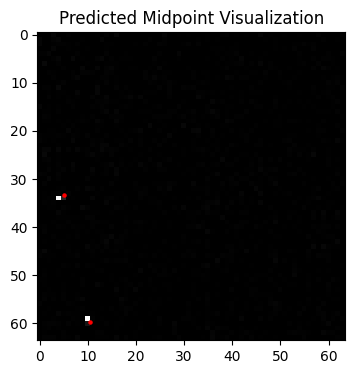

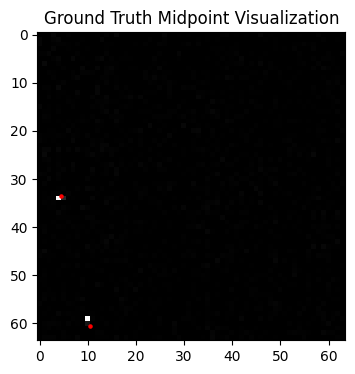

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_midpoints(image, probability_vector, midpoints, threshold=0.8):
    """
    Visualizes midpoints on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    midpoints_np = midpoints#.numpy() if hasattr(midpoints, 'numpy') else midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Predicted Midpoint Visualization")

    # Plot midpoints based on probability threshold
    for i, (y,x) in enumerate(midpoints_np):
        prob = prob_vector_np[i]
        if prob > threshold:
            plt.scatter(y,x, color='red', s=5)
            # if i == 0:  # Add label only once to avoid repetition in the legend
            #     plt.legend()

    plt.show()
    
    

t = np.random.randint(0,500)
# t=7
visualize_midpoints(tf.convert_to_tensor(inputs[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(output[1][t,0,:,:])*[64,64]) ##myprediction   

def visualize_midpoints2(image, probability_vector, midpoints, threshold=0.8):
    """
    Visualizes midpoints on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    midpoints_np = midpoints#.numpy() if hasattr(midpoints, 'numpy') else midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Ground Truth Midpoint Visualization")

    # Plot midpoints based on probability threshold
    for i, (y,x) in enumerate(midpoints_np):
        prob = prob_vector_np[i]
        if prob > threshold:
            plt.scatter(y, x, color='red', s=5)
            # if i == 0:  # Add label only once to avoid repetition in the legend
            #     plt.legend()

    plt.show()     
visualize_midpoints2(tf.convert_to_tensor(inputs[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(center_coordinates_np[t,0,:,:])*[64,64]) ##ground truth          




In [17]:
output[1][3],targets['x_midpoints_reshape'][3]

(array([[[0.05967986, 0.8164797 ],
         [0.92239034, 0.707018  ],
         [0.63721967, 0.81380445],
         [0.2583384 , 0.6136362 ],
         [0.27701148, 0.79301757],
         [0.25320438, 0.76317984],
         [0.56444603, 0.3609054 ],
         [0.45196205, 0.7908605 ],
         [0.43175274, 0.44677556],
         [0.57788014, 0.5339317 ],
         [0.52479625, 0.3910867 ],
         [0.53623533, 0.51333076]]], dtype=float32),
 <tf.Tensor: shape=(1, 12, 2), dtype=float64, numpy=
 array([[[0.0546875, 0.8359375],
         [0.9296875, 0.6953125],
         [0.       , 0.       ],
         [0.       , 0.       ],
         [0.       , 0.       ],
         [0.       , 0.       ],
         [0.       , 0.       ],
         [0.       , 0.       ],
         [0.       , 0.       ],
         [0.       , 0.       ],
         [0.       , 0.       ],
         [0.       , 0.       ]]])>)

In [16]:
import numpy as np

def evaluate_model(predictions, ground_truths, probability_threshold=0.9, midpoint_diff_threshold=0.05):
    pred_probabilities = predictions[0]
    pred_midpoints = predictions[1]
    gt_probabilities = ground_truths[0]
    gt_midpoints = ground_truths[1]
    
    # Valid predictions are those above the probability threshold
    valid_predictions = pred_probabilities > probability_threshold
    no_predictions = pred_probabilities <= probability_threshold

    # Calculate differences for midpoint evaluations
    midpoint_diff = np.abs(pred_midpoints - gt_midpoints)
    is_accurate_prediction = np.all(midpoint_diff <= midpoint_diff_threshold, axis=1)
    
    # True Positives: Valid predictions close enough to the ground truth
    TP = np.sum(np.logical_and(valid_predictions, is_accurate_prediction))
    
    # False Positives: Valid predictions not close enough to the ground truth
    FP = np.sum(np.logical_and(valid_predictions, ~is_accurate_prediction))
    
    # True Negatives: No predictions where no objects are actually present
    TN = np.sum(np.logical_and(no_predictions, gt_probabilities <= probability_threshold))
    
    # False Negatives: No predictions where objects are actually present
    FN = np.sum(np.logical_and(no_predictions, gt_probabilities > probability_threshold))
    
    # Metrics calculation
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    MAE = np.mean(midpoint_diff)
    MSE = np.mean(np.square(midpoint_diff))
    
    return precision, recall, F1_score, MAE, MSE

# Usage 
predictions = [output[0][0:800], output[1][0:800]]
ground_truths = [targets['x_prob_reshape'][0:800], targets['x_midpoints_reshape'][0:800]]
precision, recall, F1_score, MAE, MSE = evaluate_model(predictions, ground_truths)

print(f"Precision: {precision}, Recall: {recall}, F1 Score: {F1_score}, MAE: {MAE}, MSE: {MSE}")


Precision: 0.5167, Recall: 1.0, F1 Score: 0.6813476626887321, MAE: 0.2895562349019795, MSE: 0.15725937873580795
